In [1]:
import os
from google.colab import drive

# Montar el Google Drive
drive.mount('/content/drive')

# Definir la ruta del dataset
PATH = '/content/drive/MyDrive/Datasets/Garbage Classification'

# Obtener las clases del dataset
classes = os.listdir(PATH)
print(classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['cardboard', 'trash', 'metal', 'paper', 'glass', 'plastic']


In [2]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: cardboard. Imágenes: 1937
Categoría: trash. Imágenes: 695
Categoría: metal. Imágenes: 940
Categoría: paper. Imágenes: 1959
Categoría: glass. Imágenes: 3720
Categoría: plastic. Imágenes: 2273


In [3]:
imgs[:6]
len(imgs)

11524

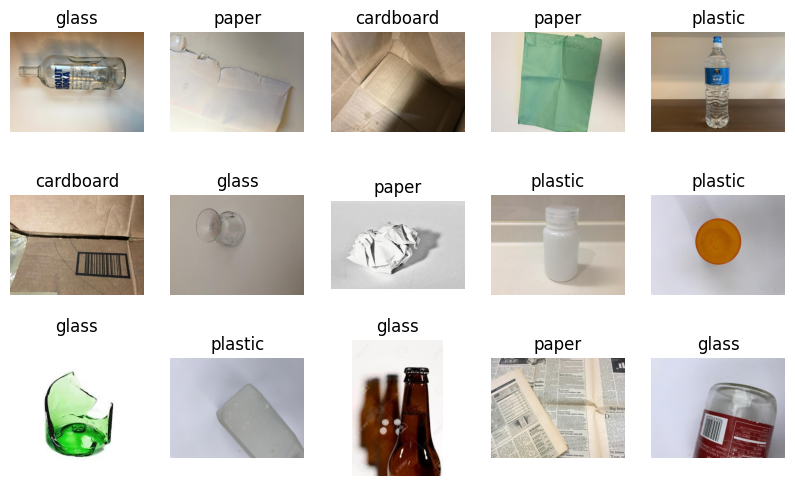

In [4]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(9219, 2305)

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [7]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(9219, 2305)

In [8]:
dataset['train'][10]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.5059, 0.6902, 0.7922],
          [1.0000, 1.0000, 1.0000,  ..., 0.8902, 0.9843, 0.6549],
          [1.0000, 1.0000, 1.0000,  ..., 0.9412, 0.9843, 0.4863],
          ...,
          [0.9451, 0.9412, 0.9373,  ..., 0.7373, 0.7373, 0.7373],
          [0.9451, 0.9412, 0.9373,  ..., 0.7373, 0.7373, 0.7373],
          [0.9451, 0.9412, 0.9373,  ..., 0.7373, 0.7373, 0.7373]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4980, 0.6980, 0.8118],
          [1.0000, 1.0000, 1.0000,  ..., 0.8902, 0.9882, 0.6431],
          [1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.9686, 0.4431],
          ...,
          [0.9529, 0.9490, 0.9451,  ..., 0.7412, 0.7412, 0.7412],
          [0.9529, 0.9490, 0.9451,  ..., 0.7412, 0.7412, 0.7412],
          [0.9529, 0.9490, 0.9451,  ..., 0.7412, 0.7412, 0.7412]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4157, 0.6392, 0.7569],
          [1.0000, 1.0000, 1.0000,  ..., 0.8157, 0.9333, 0.6078],
          [1.0000, 1.0000, 1.0000,  ...,

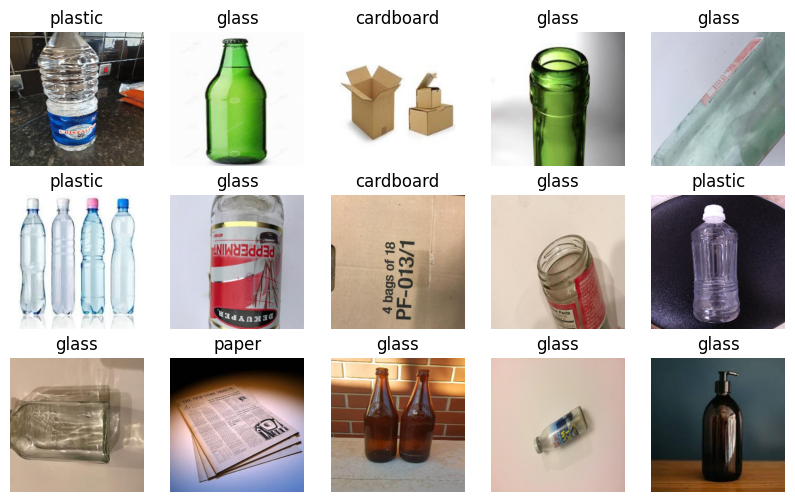

In [9]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [10]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=100, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [11]:
import torchvision

# Crear una instancia del modelo MaxVit_T con los pesos pre-entrenados en ImageNet-1K
mnasnet = torchvision.models.mnasnet1_3()
mnasnet


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [12]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=6, pretrained=False, freeze=False):
    super().__init__()
    # descargamos mnasnet
    mnasnet = torchvision.models.mnasnet1_3(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.mnasnet = torch.nn.Sequential(*list(mnasnet.children())[:-1])
    if freeze:
      for param in self.mnasnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1280*7*7, 6)

  def forward(self, x):
    x = self.mnasnet(x)
    # print(x.shape)
    x = x.view(x.shape[0], -1)
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)
    return x

  def unfreeze(self):
    for param in self.mnasnet.parameters():
        param.requires_grad=True

In [13]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 6])

In [14]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [15]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=5)

val_loss 1.88956 val_acc 0.16125: 100%|██████████| 24/24 [09:48<00:00, 24.51s/it]


Epoch 1/5 loss 5.66551 val_loss 1.88956 acc 0.29626 val_acc 0.16125


val_loss 1.78806 val_acc 0.17917: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Epoch 2/5 loss 2.39560 val_loss 1.78806 acc 0.44353 val_acc 0.17917


val_loss 1.92493 val_acc 0.17917: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Epoch 3/5 loss 1.40756 val_loss 1.92493 acc 0.54835 val_acc 0.17917


val_loss 1.81753 val_acc 0.17917: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Epoch 4/5 loss 1.04530 val_loss 1.81753 acc 0.63912 val_acc 0.17917


val_loss 3.65616 val_acc 0.18958: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]

Epoch 5/5 loss 1.02190 val_loss 3.65616 acc 0.64935 val_acc 0.18958


In [16]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_3_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 7.03702 val_acc 0.37375: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Epoch 1/5 loss 0.56441 val_loss 7.03702 acc 0.85104 val_acc 0.37375


val_loss 3.90880 val_acc 0.59667: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


Epoch 2/5 loss 0.25164 val_loss 3.90880 acc 0.94353 val_acc 0.59667


val_loss 3.34666 val_acc 0.68208: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 3/5 loss 0.16312 val_loss 3.34666 acc 0.96591 val_acc 0.68208


val_loss 1.95731 val_acc 0.71792: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Epoch 4/5 loss 0.10700 val_loss 1.95731 acc 0.97399 val_acc 0.71792


val_loss 0.80681 val_acc 0.82208: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]

Epoch 5/5 loss 0.07681 val_loss 0.80681 acc 0.97906 val_acc 0.82208


In [17]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 1.47624 val_acc 0.62667: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


Epoch 1/5 loss 0.42598 val_loss 1.47624 acc 0.88165 val_acc 0.62667


val_loss 1.05763 val_acc 0.71958: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Epoch 2/5 loss 0.07176 val_loss 1.05763 acc 0.98017 val_acc 0.71958


val_loss 2.82785 val_acc 0.42250: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 3/5 loss 0.02421 val_loss 2.82785 acc 0.99318 val_acc 0.42250


val_loss 1.46740 val_acc 0.58875: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Epoch 4/5 loss 0.06082 val_loss 1.46740 acc 0.98154 val_acc 0.58875


val_loss 9.48904 val_acc 0.32792: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]

Epoch 5/5 loss 0.04603 val_loss 9.48904 acc 0.98851 val_acc 0.32792


In [20]:
import matplotlib.pyplot as plt

def plot_predictions(model_c, dataloader, r, c):
    model_c.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model_c(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

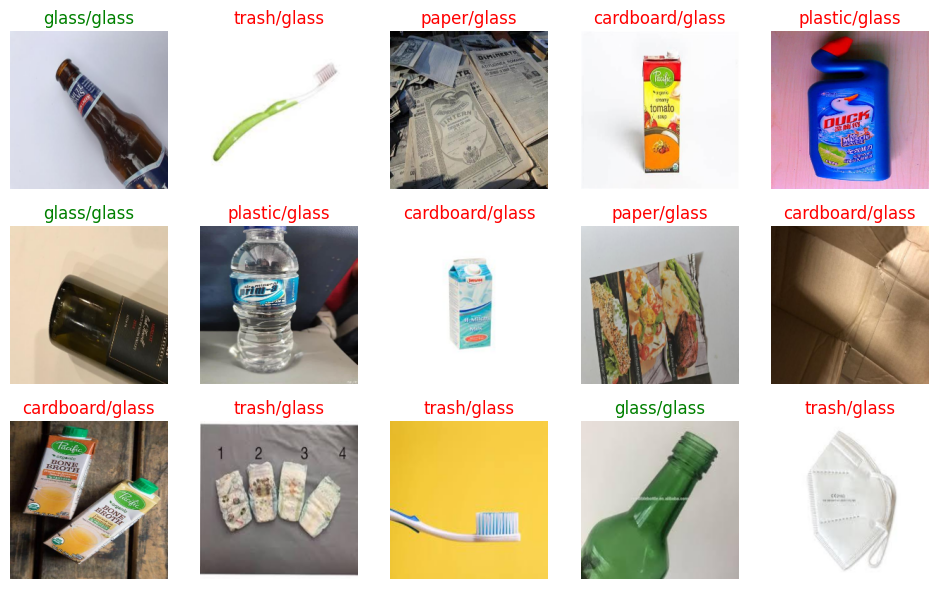

In [21]:
plot_predictions(model_c, dataloader, 3, 5)